<a href="https://colab.research.google.com/github/LolloS8/Quantitative-Investment-Toolkit/blob/main/Port_OPT_LS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Il codice è pronto uso: al massimo, sono richieste piccole modifiche per farlo funzionare.

SCRIPT 1: CALCOLO RATA PER MESE SUCCESSIVO

SCRIPT 2: BACKTESTING

SCIRPT 3: MATRICE BLACK-LITTERMAN (CALCOLO R PIU' OGGETTIVI) + VINCOLI INFRAGRUPPO

SCRIPT 4: SIMULAZIONE MONTECARLO

SCRIPT 1: CALCOLO RATA PER MESE SUCCESSIVO

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import pandas_datareader.data as web
from datetime import datetime
import os
import json

# ==============================================================================
# FUNZIONI DI ANALISI E GESTIONE DATI
# ==============================================================================

def scarica_e_prepara_dati(tickers):
    """
    Funzione unica: scarica tutti i dati necessari direttamente in memoria,
    li unisce in un'unica tabella e ignora automaticamente i ticker non trovati.
    """
    print("--- FASE A: DOWNLOAD E PREPARAZIONE DATI ---")

    dati_scaricati = yf.download(tickers, period="max", auto_adjust=True, progress=False)

    #Prendo solo i prezzi di chiusura e li isolo
    dati_prezzi = dati_scaricati['Close']

    #Rimuovo le colonne NaN
    dati_prezzi.dropna(axis=1, how='all', inplace=True)

    # Rimuove le righe con dati parziali per trovare il periodo comune
    dati_prezzi.dropna(axis=0, how='any', inplace=True)

    print("✅ Dati scaricati e uniti con successo.")
    return dati_prezzi

def pianifica_entrate_mensili(capitale_totale, mesi):
    """
    Calcola la rata mensile per un Piano di Accumulo.
    """
    print("\n--- 1. PIANIFICAZIONE DELLE ENTRATE MENSILI ---")
    if mesi <= 0: return None
    rata_mensile = capitale_totale / mesi
    print(f"Capitale Totale: {rata_mensile * mesi:,.2f} € | Durata: {mesi} mesi")
    print(f"✅ RATA MENSILE CALCOLATA: {rata_mensile:,.2f} €\n")
    return rata_mensile

def recupera_tasso_inflazione():
    """
    Recupera il tasso d'inflazione annuale dell'Eurozona da FRED.
    """
    print("--- 2. RECUPERO DATI MACROECONOMICI ---")
    try:
        end_date = datetime.now()
        start_date = end_date - pd.DateOffset(years=2)
        inflation_series = web.DataReader('CPHPTT01EZM659N', 'fred', start_date, end_date)
        if inflation_series.empty: raise ValueError("Serie inflazione vuota.")
        tasso_inflazione = inflation_series.iloc[-1, 0] / 100
        print(f"✅ Tasso d'inflazione rilevato: {tasso_inflazione:.2%}\n")
        return tasso_inflazione
    except Exception:
        print("⚠️ Impossibile scaricare dati inflazione. Si usa un default del 2%.\n")
        return 0.02

def ottimizza_portafoglio(dati_prezzi, tasso_inflazione):
    """
    Trova la combinazione di pesi che massimizza lo Sharpe Ratio REALE.
    """
    print("--- 3. OTTIMIZZAZIONE STRATEGICA DEL PORTAFOGLIO ---")

    if dati_prezzi.empty:
        print("❌ ERRORE: Nessun periodo di tempo comune trovato per gli asset scaricati.")
        return None, None

    data_inizio = dati_prezzi.index[0].strftime('%d-%m-%Y')
    data_fine = dati_prezzi.index[-1].strftime('%d-%m-%Y')
    print(f"✅ Trovato periodo di dati comune: dal {data_inizio} al {data_fine}.")
    print("Calcolo dell'allocazione ottimale...")

    rendimenti_log = np.log(dati_prezzi / dati_prezzi.shift(1)).dropna()
    rendimenti_medi = rendimenti_log.mean()
    matrice_cov = rendimenti_log.cov()
    num_assets = len(rendimenti_log.columns)

    def calcola_metriche(weights):
        rendimento = np.sum(rendimenti_medi * weights) * 252
        volatilita = np.sqrt(np.dot(weights.T, np.dot(matrice_cov * 252, weights)))
        sharpe = (rendimento - tasso_inflazione) / volatilita
        return rendimento, volatilita, sharpe

    def negativo_sharpe_ratio(weights):
        return -calcola_metriche(weights)[2]

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    risultato_ottimizzazione = minimize(negativo_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    pesi_ottimali = risultato_ottimizzazione.x

    print("✅ Ottimizzazione completata.\n")
    print("--- RISULTATI OTTIMIZZAZIONE ---")
    risultati_df = pd.DataFrame({'Ticker': rendimenti_log.columns, 'Peso Ottimale': [f"{p:.2%}" for p in pesi_ottimali]})
    print(risultati_df.to_string(index=False))

    return pesi_ottimali, rendimenti_log.columns.tolist()

def genera_piano_pac_mensile(pesi_ottimali, tickers, rata_mensile):
    """
    Genera il piano di acquisto operativo per la rata mensile del PAC.
    """
    print("\n" + "="*55)
    print("🎯 PIANO OPERATIVO PAC - RATA DI QUESTO MESE 🎯")
    print(f"="*55)
    print(f"Con la tua rata mensile di {rata_mensile:,.2f} €, ecco cosa comprare:\n")

    try:
        ultimi_prezzi_df = yf.Tickers(' '.join(tickers)).history(period='2d')['Close']
        piano_investimento = []
        for i, ticker in enumerate(tickers):
            peso = pesi_ottimali[i]
            importo_da_investire = rata_mensile * peso
            ultimo_prezzo = ultimi_prezzi_df[ticker].dropna().iloc[-1]
            quote_da_comprare = importo_da_investire / ultimo_prezzo if ultimo_prezzo > 0 else 0
            piano_investimento.append({"Ticker": ticker, "Importo da Investire (€)": f"{importo_da_investire:,.2f}", "Quote da Acquistare": f"{quote_da_comprare:.4f}"})
        df_piano = pd.DataFrame(piano_investimento)
        print(df_piano.to_string(index=False))
    except Exception as e:
        print(f"\n❌ Errore nella generazione del piano PAC: {e}")

def salva_pesi_su_file(pesi, tickers, filename='pesi_ottimali.json'):
    """
    Salva i pesi ottimali calcolati in un file JSON per essere usati da altri script.
    """
    allocazione = {ticker: peso for ticker, peso in zip(tickers, pesi)}
    try:
        with open(filename, 'w') as f:
            json.dump(allocazione, f, indent=4)
        print(f"\n✅ Allocazione ottimale salvata con successo nel file '{filename}'.")
    except Exception as e:
        print(f"\n❌ Errore durante il salvataggio dei pesi: {e}")

# ==============================================================================
# ESECUZIONE PRINCIPALE DELLO SCRIPT
# ==============================================================================
if __name__ == '__main__':
    # Lista finale e verificata dei ticker
    tickers_portafoglio = [
        'IWDA.AS', 'IS3N.DE', 'HDRO.MI', 'IS04.DE', 'IPRV.AS',
        'CMEX.DE', # Questo ticker fallirà, ma lo script lo ignorerà
        'NUKL.DE', 'IUSN.DE', 'SAN.PA', 'DGTL.MI'
    ]

    # Il codice ora è un flusso unico e lineare
    dati_prezzi = scarica_e_prepara_dati(tickers_portafoglio)

    if dati_prezzi is not None and not dati_prezzi.empty:
        rata_mensile = pianifica_entrate_mensili(
            capitale_totale=float(input("➡️  Inserisci il capitale totale da investire (es. 10000): ")),
            mesi=int(input("➡️  Inserisci la durata del PAC in mesi (es. 20): "))
        )

        if rata_mensile:
            tasso_inflazione = recupera_tasso_inflazione()
            pesi_ottimali, tickers_validi = ottimizza_portafoglio(dati_prezzi, tasso_inflazione)

            if pesi_ottimali is not None:
                genera_piano_pac_mensile(pesi_ottimali, tickers_validi, rata_mensile)
                salva_pesi_su_file(pesi_ottimali, tickers_validi)

--- FASE A: DOWNLOAD E PREPARAZIONE DATI ---


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CMEX.DE']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-1490297328.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dati_prezzi.dropna(axis=1, how='all', inplace=True)
/tmp/ipython-input-1490297328.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dati_prezzi.dropna(axis=0, how='any', inplace=True)


✅ Dati scaricati e uniti con successo.
➡️  Inserisci il capitale totale da investire (es. 10000): 2200
➡️  Inserisci la durata del PAC in mesi (es. 20): 12

--- 1. PIANIFICAZIONE DELLE ENTRATE MENSILI ---
Capitale Totale: 2,200.00 € | Durata: 12 mesi
✅ RATA MENSILE CALCOLATA: 183.33 €

--- 2. RECUPERO DATI MACROECONOMICI ---
⚠️ Impossibile scaricare dati inflazione. Si usa un default del 2%.

--- 3. OTTIMIZZAZIONE STRATEGICA DEL PORTAFOGLIO ---
✅ Trovato periodo di dati comune: dal 03-02-2023 al 22-08-2025.
Calcolo dell'allocazione ottimale...
✅ Ottimizzazione completata.

--- RISULTATI OTTIMIZZAZIONE ---
 Ticker Peso Ottimale
DGTL.MI         0.00%
HDRO.MI         0.00%
IPRV.AS         0.00%
IS04.DE         0.00%
IS3N.DE         0.00%
IUSN.DE         0.00%
IWDA.AS        68.85%
NUKL.DE        31.07%
 SAN.PA         0.07%

🎯 PIANO OPERATIVO PAC - RATA DI QUESTO MESE 🎯
Con la tua rata mensile di 183.33 €, ecco cosa comprare:



[*********************100%***********************]  9 of 9 completed


 Ticker Importo da Investire (€) Quote da Acquistare
DGTL.MI                     0.00              0.0000
HDRO.MI                     0.00              0.0000
IPRV.AS                     0.00              0.0000
IS04.DE                     0.00              0.0000
IS3N.DE                     0.00              0.0000
IUSN.DE                     0.00              0.0000
IWDA.AS                   126.23              1.2010
NUKL.DE                    56.97              1.3814
 SAN.PA                     0.13              0.0015

✅ Allocazione ottimale salvata con successo nel file 'pesi_ottimali.json'.


SCRIPT 2: BACKTESTING

✅ Allocazione strategica caricata con successo da 'pesi_ottimali.json'.
--- 1. PREPARAZIONE DEI DATI PER IL BACKTEST ---
✅ Il backtest inizierà da 03-02-2023.

--- 2. SIMULAZIONE DELL'INVESTIMENTO SCAGLIONATO ---
✅ Simulazione completata.

--- 3. ANALISI DELLE PERFORMANCE ---
Capitale Iniziale:            2,200.00 €
Valore Finale Totale:         3,227.64 € (Investimenti + Cash)
Guadagno/Perdita Netta:       1,027.64 €
Ritorno Totale (ROI):         46.71%
Massimo Drawdown:             -26.32% (sul valore netto totale)

--- 4. GENERAZIONE DEL GRAFICO ---


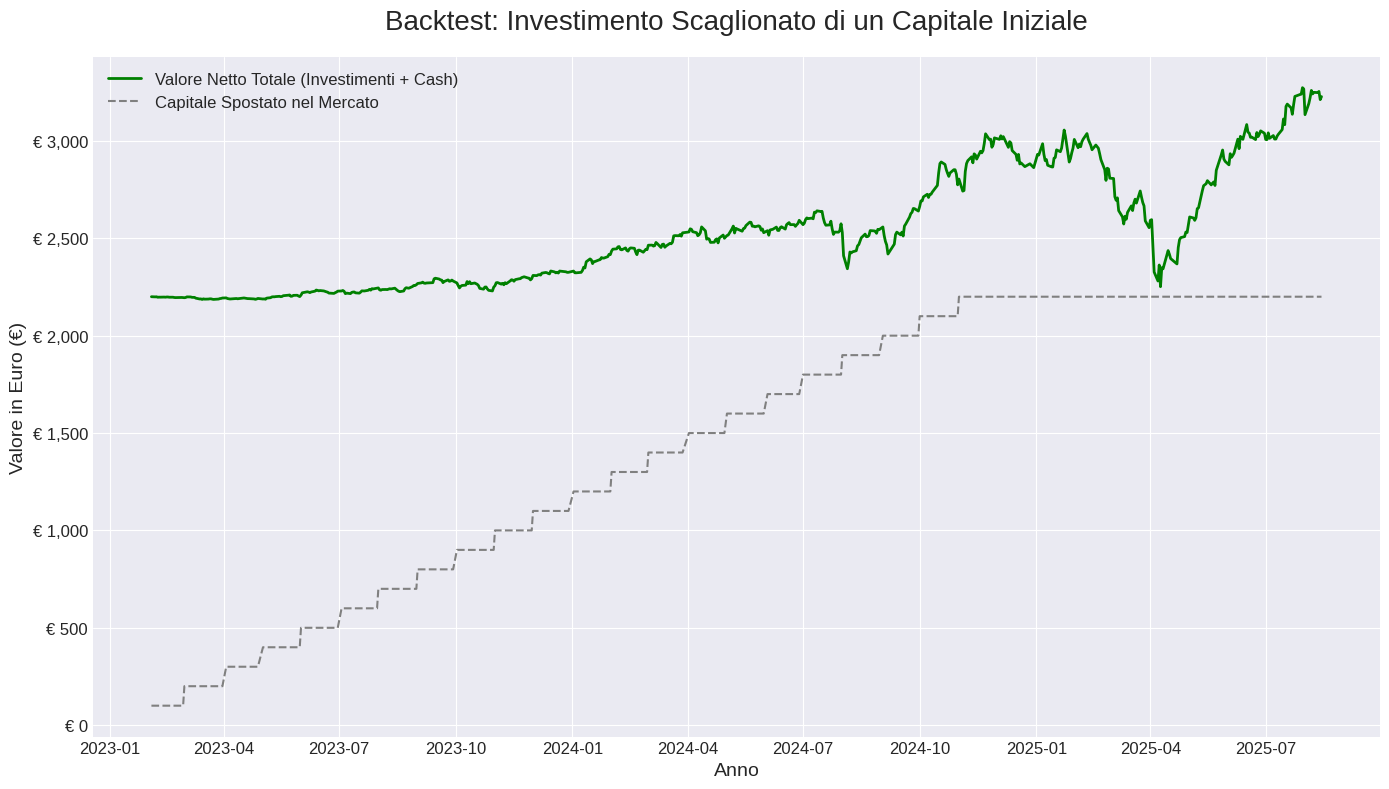

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import json
from datetime import datetime

# ==============================================================================
# FUNZIONI DI CARICAMENTO E BACKTEST
# ==============================================================================

def carica_pesi_da_file(filename='pesi_ottimali.json'):
    """
    Carica l'allocazione di portafoglio da un file JSON.
    """
    try:
        with open(filename, 'r') as f:
            allocazione = json.load(f)
        print(f"✅ Allocazione strategica caricata con successo da '{filename}'.")
        return allocazione
    except FileNotFoundError:
        print(f"❌ ERRORE: File '{filename}' non trovato.")
        print("   Assicurati di eseguire prima lo Script 1 per generare questo file.")
        return None
    except Exception as e:
        print(f"❌ Errore durante la lettura del file dei pesi: {e}")
        return None

def esegui_backtest_scaglionato(data_inizio, data_fine, capitale_da_scaglionare, versamento_mensile, allocazione_pesi):
    """
    Simula un investimento scaglionato con una logica di calcolo giornaliera robusta.
    """
    print("--- 1. PREPARAZIONE DEI DATI PER IL BACKTEST ---")

    tickers = [t for t, p in allocazione_pesi.items() if p > 0]
    if not tickers:
        print("❌ Nessun asset con peso maggiore di zero. Impossibile eseguire il backtest.")
        return

    try:
        dati_storici = yf.download(tickers, start=data_inizio, end=data_fine, progress=False, auto_adjust=True)['Close']
    except Exception as e:
        print(f"❌ Errore nel download dei dati storici: {e}")
        return

    dati_storici.dropna(inplace=True)
    primo_giorno_comune = dati_storici.index.min()
    dati_storici = dati_storici[primo_giorno_comune:] # Filtra i dati per iniziare dal primo giorno utile
    print(f"✅ Il backtest inizierà da {primo_giorno_comune.strftime('%d-%m-%Y')}.\n")

    print("--- 2. SIMULAZIONE DELL'INVESTIMENTO SCAGLIONATO ---")

    # Inizializzo le variabili
    cash = capitale_da_scaglionare
    holdings = {ticker: 0.0 for ticker in tickers}

    # Liste per salvare i valori giornalieri
    date_log = []
    valore_netto_log = []
    capitale_investito_log = []

    # Trova le date di investimento (primo giorno di trading di ogni mese)
    investimenti_mensili = dati_storici.groupby([dati_storici.index.year, dati_storici.index.month]).head(1).index

    # Ciclo su ogni giorno di trading
    for data_corrente in dati_storici.index:
        # Controllo se oggi è un giorno di investimento
        if data_corrente in investimenti_mensili and cash > 0:
            investimento_effettivo = min(versamento_mensile, cash)
            cash -= investimento_effettivo

            for ticker in tickers:
                prezzo_acquisto = dati_storici.loc[data_corrente, ticker]
                importo_per_ticker = investimento_effettivo * allocazione_pesi[ticker]
                quote_acquistate = importo_per_ticker / prezzo_acquisto
                holdings[ticker] += quote_acquistate

        # Calcolo il valore del portafoglio in questo giorno
        valore_investimenti = 0
        for ticker in tickers:
            valore_investimenti += holdings[ticker] * dati_storici.loc[data_corrente, ticker]

        # Calcolo il valore netto totale (investimenti + cash rimanente)
        valore_netto_totale = valore_investimenti + cash
        capitale_investito = capitale_da_scaglionare - cash

        # Salvo i log giornalieri
        date_log.append(data_corrente)
        valore_netto_log.append(valore_netto_totale)
        capitale_investito_log.append(capitale_investito)

    # Crea il DataFrame finale dai log
    portafoglio = pd.DataFrame({
        'valore_netto_totale': valore_netto_log,
        'capitale_investito_mercato': capitale_investito_log
    }, index=date_log)

    print("✅ Simulazione completata.\n")

    print("--- 3. ANALISI DELLE PERFORMANCE ---")
    valore_finale = portafoglio['valore_netto_totale'].iloc[-1]
    guadagno_netto = valore_finale - capitale_da_scaglionare
    ritorno_totale = (valore_finale / capitale_da_scaglionare - 1) * 100 if capitale_da_scaglionare > 0 else 0

    massimo_precedente = portafoglio['valore_netto_totale'].cummax()
    drawdown = (portafoglio['valore_netto_totale'] - massimo_precedente) / massimo_precedente
    max_drawdown = drawdown.min() * 100

    print(f"Capitale Iniziale:            {capitale_da_scaglionare:,.2f} €")
    print(f"Valore Finale Totale:         {valore_finale:,.2f} € (Investimenti + Cash)")
    print(f"Guadagno/Perdita Netta:       {guadagno_netto:,.2f} €")
    print(f"Ritorno Totale (ROI):         {ritorno_totale:.2f}%")
    print(f"Massimo Drawdown:             {max_drawdown:.2f}% (sul valore netto totale)\n")

    print("--- 4. GENERAZIONE DEL GRAFICO ---")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(portafoglio.index, portafoglio['valore_netto_totale'], label='Valore Netto Totale (Investimenti + Cash)', color='green', linewidth=2)
    ax.plot(portafoglio.index, portafoglio['capitale_investito_mercato'], label='Capitale Spostato nel Mercato', color='gray', linestyle='--')
    ax.set_title('Backtest: Investimento Scaglionato di un Capitale Iniziale', fontsize=20, pad=20)
    ax.set_ylabel('Valore in Euro (€)', fontsize=14)
    ax.set_xlabel('Anno', fontsize=14)
    ax.legend(loc='upper left', fontsize=12)

    def euro_formatter(x, pos):
        return f'€ {int(x):,}'
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(euro_formatter))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==============================================================================
# CONFIGURAZIONE E ESECUZIONE
# ==============================================================================
if __name__ == '__main__':
    allocazione_ottimale = carica_pesi_da_file()

    if allocazione_ottimale:
        # Definisci i parametri per la simulazione
        DATA_INIZIO_BACKTEST = '2023-01-01'
        DATA_FINE_BACKTEST = datetime.now().strftime('%Y-%m-%d')
        CAPITALE_DA_SCAGLIONARE = 2200.00
        VERSAMENTO_MENSILE = 100.00

        esegui_backtest_scaglionato(
            DATA_INIZIO_BACKTEST,
            DATA_FINE_BACKTEST,
            CAPITALE_DA_SCAGLIONARE,
            VERSAMENTO_MENSILE,
            allocazione_ottimale
        )

SCRIPT 3: MATRICE BLACK-LITTERMAN

In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt import BlackLittermanModel, risk_models, EfficientFrontier, plotting
import matplotlib.pyplot as plt
import json

# ==============================================================================
# FUNZIONI DI PREPARAZIONE (Invariate)
# ==============================================================================
def scarica_e_prepara_dati(tickers):
    print("--- 1. DOWNLOAD E PREPARAZIONE DATI DI MERCATO ---")
    try:
        dati_prezzi = yf.download(tickers, period="5y", auto_adjust=True, progress=False)['Close']
        dati_prezzi.dropna(axis=1, how='all', inplace=True)
        dati_prezzi.dropna(axis=0, how='any', inplace=True)
        tickers_validi = dati_prezzi.columns.tolist()
        print(f"✅ Dati scaricati per {len(tickers_validi)} ticker validi.\n")
        return dati_prezzi, tickers_validi
    except Exception as e:
        print(f"❌ Errore durante il download dei dati: {e}")
        return None, None

# ==============================================================================
# SCRIPT PRINCIPALE
# ==============================================================================
if __name__ == '__main__':
    tickers_portafoglio = [
        'IWDA.AS', 'IS3N.DE', 'IUSN.DE', 'SAN.PA', # Gruppo Azionario Core
        'DGTL.MI', 'HDRO.MI', 'NUKL.DE',          # Gruppo Azionario Tematico
        'IS04.DE', 'IPRV.AS'                       # Gruppo Alternativi/Decorrelati
    ]

    dati_prezzi, tickers_validi = scarica_e_prepara_dati(tickers_portafoglio)

    if dati_prezzi is not None:
        # --- 2. SETUP DEL MODELLO BLACK-LITTERMAN ---
        print("--- 2. CALCOLO DELLE ASPETTATIVE IMPLICITE DEL MERCATO ---")
        S = risk_models.sample_cov(dati_prezzi)
        market_caps = {ticker: 1 for ticker in tickers_validi}
        from pypfopt.black_litterman import market_implied_prior_returns
        prior = market_implied_prior_returns(market_caps, 2.5, S)
        print("Rendimenti attesi impliciti nel mercato:")
        print(prior.map('{:.2%}'.format))

        # --- 3. DEFINISCI LE TUE "VIEWS" PERSONALI ---
        print("\n--- 3. INTEGRAZIONE DELLE TUE CONVINZIONI (VIEWS) ---")
        viewdict = { 'HDRO.MI': 0.15, 'DGTL.MI': 0.12, 'IS04.DE': 0.04, 'NUKL.DE': -0.02 }
        defined_views = {k: v for k, v in viewdict.items() if k in tickers_validi}
        tickers_con_view = list(defined_views.keys())
        P = np.zeros((len(defined_views), len(tickers_validi)))
        Q = np.array([defined_views[ticker] for ticker in tickers_con_view])
        for i, ticker in enumerate(tickers_con_view):
            P[i, tickers_validi.index(ticker)] = 1
        print("Le tue views sono state incorporate nel modello.")

        # --- 4. CALCOLO DEI RENDIMENTI ATTESI POSTERIORI ---
        print("\n--- 4. CALCOLO DEI RENDIMENTI ATTESI POSTERIORI ---")
        bl = BlackLittermanModel(S, pi=prior, P=P, Q=Q)
        ret_bl = bl.bl_returns()
        print("Rendimenti attesi finali (mercato + tue views):")
        print(ret_bl.map('{:.2%}'.format))

        # --- 5. OTTIMIZZAZIONE FINALE CON VINCOLI DI GRUPPO ---
        print("\n--- 5. CALCOLO DEL PORTAFOGLIO OTTIMALE FINALE CON VINCOLI ---")

        ef = EfficientFrontier(ret_bl, S)

        # --- INIZIO NUOVA SEZIONE: VINCOLI INFRAGRUPPO ---
        # 1. Definisci i tuoi gruppi (chi appartiene a cosa) -> Definisco i gruppi (es:az.core, tematico,alternativo)
        sector_mapper = {
            'IWDA.AS': 'Azionario Core', 'IS3N.DE': 'Azionario Core', 'IUSN.DE': 'Azionario Core', 'SAN.PA': 'Azionario Core',
            'DGTL.MI': 'Azionario Tematico', 'HDRO.MI': 'Azionario Tematico', 'NUKL.DE': 'Azionario Tematico',
            'IS04.DE': 'Alternativi', 'IPRV.AS': 'Alternativi'
        }

        # 2. Definisci i limiti minimi e massimi per ogni gruppo
        # ESEMPIO: Vogliamo che il Core sia almeno il 50%, i Tematici non più del 30%, etc.
        sector_lower = {'Azionario Core': 0.50, 'Azionario Tematico': 0.10, 'Alternativi': 0.05}
        sector_upper = {'Azionario Core': 0.70, 'Azionario Tematico': 0.30, 'Alternativi': 0.20}

        # 3. Aggiungi i vincoli all'ottimizzatore
        ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
        print("✅ Vincoli di peso infragruppo applicati.")
        # --- FINE NUOVA SEZIONE ---

        ef.max_sharpe()
        weights = ef.clean_weights()

        print("\nAllocazione ottimale finale (con vincoli):")
        for ticker, weight in weights.items():
            if weight > 0:
                print(f"- {ticker}: {weight:.2%}")

        ef.portfolio_performance(verbose=True)

SCRIPT 4: SIMULAZIONE MONTECARLO

--- 1. PREPARAZIONE DATI STORICI PER LA SIMULAZIONE ---
✅ Parametri statistici calcolati.

--- 2. ESECUZIONE DI 5,000 SIMULAZIONI MONTECARLO ---
✅ Simulazioni completate.

--- 3. ANALISI E VISUALIZZAZIONE DEI RISULTATI ---


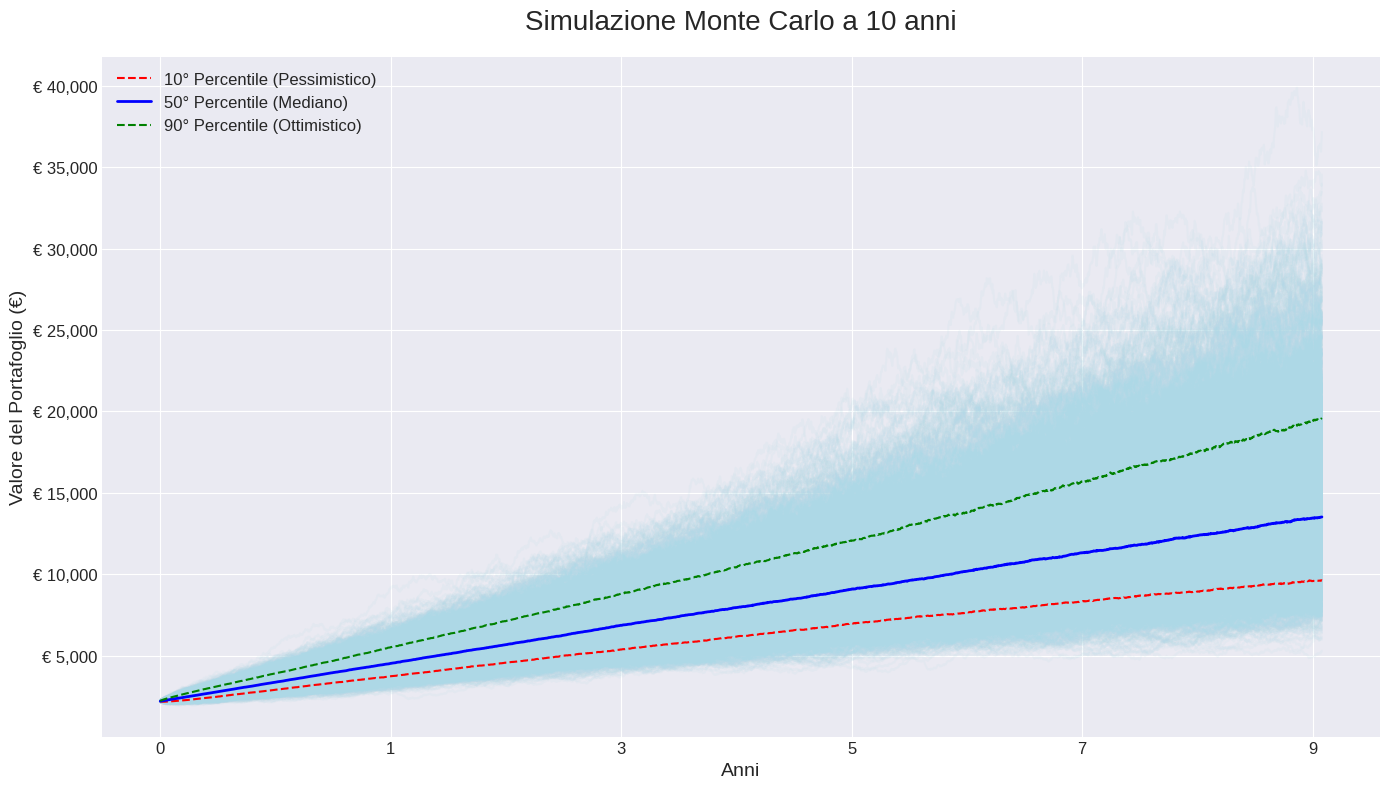


Statistiche sul valore finale del portafoglio:
Scenario Peggiore (5° percentile):    € 8,790.27
Scenario Pessimistico (10° percentile): € 9,609.69
Scenario Mediano (50° percentile):      € 13,515.52
Scenario Ottimistico (90° percentile):  € 19,587.47
Miglior Scenario (95° percentile):    € 21,781.62


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ==============================================================================
# CONFIGURAZIONE DELLA SIMULAZIONE
# ==============================================================================
PESI_PORTAFOGLIO = {
    'DGTL.MI': 0.2845, 'HDRO.MI': 0.0977, 'IS04.DE': 0.1806, 'IS3N.DE': 0.0355,
    'IUSN.DE': 0.1392, 'IWDA.AS': 0.0892, 'SAN.PA':  0.1734, 'NUKL.DE': 0.0, 'IPRV.AS': 0.0
}
ORIZZONTE_ANNI = 10
CAPITALE_INIZIALE = 2200
CONTRIBUTO_MENSILE = 100
NUMERO_SIMULAZIONI = 5000

# ==============================================================================
# FUNZIONI DELLO SCRIPT
# ==============================================================================

def prepara_dati_per_simulazione(tickers):
    """
    Scarica i dati storici e calcola i parametri statistici necessari.
    """
    print("--- 1. PREPARAZIONE DATI STORICI PER LA SIMULAZIONE ---")
    try:
        dati_prezzi = yf.download(tickers, period="10y", auto_adjust=True, progress=False)['Close']
        rendimenti_log = np.log(dati_prezzi / dati_prezzi.shift(1))
        rendimenti_medi = rendimenti_log.mean()
        matrice_cov = rendimenti_log.cov()
        print("✅ Parametri statistici calcolati.\n")
        return rendimenti_medi, matrice_cov
    except Exception as e:
        print(f"❌ Errore nel download o calcolo dei dati: {e}")
        return None, None

def esegui_simulazione_montecarlo(pesi, rendimenti_medi, matrice_cov):
    """
    Esegue la simulazione Monte Carlo per il portafoglio in modo efficiente.
    """
    print(f"--- 2. ESECUZIONE DI {NUMERO_SIMULAZIONI:,} SIMULAZIONI MONTECARLO ---")

    num_giorni = ORIZZONTE_ANNI * 252
    rendimento_portafoglio = np.sum(rendimenti_medi * pesi) * 252
    volatilita_portafoglio = np.sqrt(np.dot(pesi.T, np.dot(matrice_cov * 252, pesi)))

    # --- INIZIO DELLA CORREZIONE ---
    # Usiamo un dizionario per raccogliere tutti i risultati, che è molto più veloce.
    risultati_dict = {}

    for i in range(NUMERO_SIMULAZIONI):
        rendimenti_giornalieri = np.random.normal(rendimento_portafoglio / 252, volatilita_portafoglio / np.sqrt(252), num_giorni)

        percorso_capitale = [CAPITALE_INIZIALE]
        for giorno in range(num_giorni):
            capitale_giorno_precedente = percorso_capitale[-1]
            capitale_con_contributo = capitale_giorno_precedente + (CONTRIBUTO_MENSILE * 12 / 252)
            capitale_giorno_successivo = capitale_con_contributo * (1 + rendimenti_giornalieri[giorno])
            percorso_capitale.append(capitale_giorno_successivo)

        risultati_dict[f'Simulazione {i+1}'] = percorso_capitale

    # Creiamo il DataFrame finale in un unico passaggio. Questo è il metodo efficiente.
    risultati_simulazioni = pd.DataFrame(risultati_dict)
    # --- FINE DELLA CORREZIONE ---

    print("✅ Simulazioni completate.\n")
    return risultati_simulazioni

def visualizza_risultati(risultati_df):
    """
    Mostra i risultati della simulazione con un grafico e delle statistiche.
    """
    print("--- 3. ANALISI E VISUALIZZAZIONE DEI RISULTATI ---")

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    ax.plot(risultati_df, alpha=0.1, color='lightblue')
    ax.plot(risultati_df.quantile(0.10, axis=1), color='red', linestyle='--', label='10° Percentile (Pessimistico)')
    ax.plot(risultati_df.quantile(0.50, axis=1), color='blue', linewidth=2, label='50° Percentile (Mediano)')
    ax.plot(risultati_df.quantile(0.90, axis=1), color='green', linestyle='--', label='90° Percentile (Ottimistico)')

    ax.set_title(f'Simulazione Monte Carlo a {ORIZZONTE_ANNI} anni', fontsize=20, pad=20)
    ax.set_ylabel('Valore del Portafoglio (€)', fontsize=14)
    ax.set_xlabel('Anni', fontsize=14)
    ax.legend(loc='upper left', fontsize=12)

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{int(x/252)}'))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'€ {int(x):,}'))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    valori_finali = risultati_df.iloc[-1]
    print("\nStatistiche sul valore finale del portafoglio:")
    print(f"Scenario Peggiore (5° percentile):    € {valori_finali.quantile(0.05):,.2f}")
    print(f"Scenario Pessimistico (10° percentile): € {valori_finali.quantile(0.10):,.2f}")
    print(f"Scenario Mediano (50° percentile):      € {valori_finali.quantile(0.50):,.2f}")
    print(f"Scenario Ottimistico (90° percentile):  € {valori_finali.quantile(0.90):,.2f}")
    print(f"Miglior Scenario (95° percentile):    € {valori_finali.quantile(0.95):,.2f}")

# ==============================================================================
# ESECUZIONE PRINCIPALE
# ==============================================================================
if __name__ == '__main__':
    tickers_attivi = [ticker for ticker, peso in PESI_PORTAFOGLIO.items() if peso > 0]

    rendimenti_medi, matrice_cov = prepara_dati_per_simulazione(tickers_attivi)

    if rendimenti_medi is not None:
        pesi_vettore = pd.Series([PESI_PORTAFOGLIO[ticker] for ticker in rendimenti_medi.index])

        risultati = esegui_simulazione_montecarlo(pesi_vettore, rendimenti_medi, matrice_cov)
        visualizza_risultati(risultati)